In [1]:
%matplotlib inline

import os
import glob

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table

from desispec.interpolation import resample_flux

from collections import Counter

import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rc('font', family='serif', size=16)

In [2]:
# Load in the data
basedir = '/Users/ryanrubenzahl/Documents/DESI/my_outlier_detection/'
specdir = 'galaxy_sim_catalog/spectra/'
expid = 4

sn_dir = 'distscale_atpeak'             
gal_globpath = basedir + specdir + 'galaxies/*expid%03d*.fits' % expid
sn_globpath  = basedir + specdir + sn_dir + '/*expid%03d*.fits' % expid

# Galaxies without supernovae
gal_files = glob.glob(gal_globpath)
# Galaxies with supernovae
sn_host_files = glob.glob(sn_globpath)
# All the files
all_files = np.append(gal_files, sn_host_files)

print len(gal_files), "total galaxies"
print len(sn_host_files), "total sn hosts"

21000 total galaxies
18900 total sn hosts


## Read in the data to an astropy table

In [3]:
data = []

for n, f in enumerate(all_files):
        
    # Read the fits file
    with fits.open(f, memmap=0) as hdul:

        specid  = os.path.basename(f)[8:31] # Spectra ID tag
        objtype = hdul[0].header['OBJTYPE'] # Object type (e.g. BGS)

        # Throw out non-galaxy types (sky/calib star)
        if objtype in ['SKY', 'FSTD']:
            continue
        else:
            has_sn  = hdul[0].header['HAS_SN'] # flag indicating SN or not
            Z    = hdul[0].header['REDSHIFT']  # redshift of the spectrum
            mag  = hdul[0].header['MAG']       # magnitude of host galaxy
            wave = hdul[1].data / (Z+1) # wavelength shifted to rest frame
            if not has_sn:
                flux = hdul[2].data * 1e-17 # gal fluxes aren't in units
                sn_epoch = np.nan           # placeholder for empty epoch
            else:
                flux = hdul[2].data         # flux values
                sn_epoch = hdul[0].header['SN_EPOCH'] # supernova epoch
            ivar = hdul[3].data # inverse variance (in the flux)
            # TODO: FIX IVAR UNIT HERE
            
            # Create a new table row
            new_row = [specid, objtype, has_sn, sn_epoch, 
                       Z, mag, wave, flux, ivar]
            
            # And add it to the table
            data.append(new_row)


In [4]:
# spec_table = Table(rows=data,
#                  names=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 
#                           'REDSHIFT', 'MAG', 'WAVE', 'FLUX', 'IVAR'),
#                  dtype=('S23', 'S4', 'S5', float, 
#                         float, float, list, list, list))

spec_df = pd.DataFrame(data=data, 
                      columns=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 
                          'REDSHIFT', 'MAG', 'WAVE', 'FLUX', 'IVAR'))
spec_table = Table.from_pandas(spec_df)

## Eigenspectra Analysis

In [5]:
# Read in the eigenbasis
eigentable = np.genfromtxt(basedir + 'galaxy_sim_catalog/eigenspectra.txt')

global_wavelength_grid = eigentable[0]
eigenspectra = eigentable[1:]

In [6]:
# Resample spectra to a common wavelength grid
resample_fluxes  = []
resample_ivars   = []
continuum_fluxes = []
for spectra in spec_table:
    spec_flux_resample, spec_ivar_resample = resample_flux(
                             global_wavelength_grid, 
                             spectra['WAVE'], 
                             spectra['FLUX'],
                             ivar=spectra['IVAR'], 
                             extrapolate=False
                            )
    resample_fluxes.append(spec_flux_resample)
    resample_ivars.append(spec_ivar_resample)
    
    # Project/fit the basis to the spectrum
    basis_fit     = np.dot(np.linalg.pinv(eigenspectra.T), 
                           spec_flux_resample)
    bestfit_flux  = np.dot(basis_fit, eigenspectra)
    
    continuum_fluxes.append(bestfit_flux)
    
spec_table['RESAMPLED_FLUX'] = resample_fluxes
spec_table['RESAMPLED_IVAR'] = resample_ivars
spec_table['CONTINUUM_FLUX'] = continuum_fluxes

In [8]:
# Get a table for all the galaxies with and without supernovae
galaxy_table  = spec_table[spec_table['HAS_SN'] == False]
sn_host_table = spec_table[spec_table['HAS_SN'] != False]

print len(spec_table)
print len(galaxy_table), len(sn_host_table)

37800
18900 18900


## Measure amplitudes of features

Table of feature boundaries in type Ia supernova spectra

from https://arxiv.org/pdf/1011.6227.pdf

| Feature | Dominating line | Lower region (centre A) | Upper region (centre A) | Rest wavelength (A) |
|---------||----------------|-------------------------||---------------|
|f1 | Ca II H&K           | 3450 - 3800 | 3800 - 4100 | 3945.12 |
|f2 | Si II $\lambda$4000 | 3800 - 3950 | 4000 - 4200 | 4129.73 |
|f3 | Mg II $\lambda$4300 | 3850 - 4250 | 4300 - 4700 | 4481.20 |
|f4 | Fe II $\lambda$4800 | 4300 - 4700 | 4950 - 5600 | 5083.42 |
|f5 | S II W              | 5050 - 5300 | 5500 - 5750 | 5536.24 |
|f6 | Si II $\lambda$5800 | 5400 - 5700 | 5800 - 6000 | 6007.70 |
|f7 | Si II $\lambda$6150 | 5800 - 6100 | 6200 - 6600 | 6355.21 |

In [9]:
features = {
#   id     center    min    max
    "f1": [3800, 3700, 3900],
    "f2": [4000, 3950, 4100],
    "f3": [4300, 4200, 4400],
    "f4": [4850, 4700, 5000],
    "f5": [5450, 5300, 5600],
    "f6": [5800, 5700, 5900],
    "f7": [6150, 6000, 6300],
}
featurenames = {
#   id     center    min    max
    "f1": "Ca II H&K",
    "f2": "Si II $\lambda$4000",
    "f3": "Mg II $\lambda$4300",
    "f4": "Fe II $\lambda$4800",
    "f5": "S II W",
    "f6": "Si II $\lambda$5800",
    "f7": "Si II $\lambda$6150",
}

In [12]:
from scipy.optimize import curve_fit

# Define functions to fit, centered at the feature
def gaussian(x, a, c):
    return a * np.exp(-(x - feature_wavecenter)**2 / c)

def poly(x, a, b, c):
    return a + b*(x - feature_wavecenter) + c*(x - feature_wavecenter)**2

In [13]:
def get_amplitude(f, feature, spectrum):
    
    feature_data = features[feature]
    feature_wavecenter, feature_wavemin, feature_wavemax = feature_data

    # Select out the region of the spectra surrounding the feature
    cut = ((global_wavelength_grid > feature_wavemin) &
            (global_wavelength_grid < feature_wavemax))
    
    # Normalize flux to get representative amplitudes
    norm = np.linalg.norm(spectrum['RESIDUAL_FLUX'])
    
    feature_wave = global_wavelength_grid[cut]
    feature_flux = spectrum['RESIDUAL_FLUX'][cut] / norm
    feature_err = 1e-17 / np.sqrt(spectrum['RESAMPLED_IVAR'][cut]) / norm
    
    # Do the fit
    popt, pcov = curve_fit(f, feature_wave, feature_flux, 
                            sigma=feature_err, method='lm'
                          )
        
    fit = f(feature_wave, *popt)
    amplitude = (np.max(fit) - np.min(fit)) / np.mean(feature_err)
        
    return amplitude, fit


array([[193],
       [194],
       [195],
       [197],
       [198],
       [199],
       [201],
       [202],
       [203],
       [204]])

In [15]:
feature_poly_amplitudes = []
feature_gaussian_amplitudes = []
fitfailed = 0

for spectrum in spec_table:
    poly_amplitudes = []
    gaussian_amplitudes = []
    for feature in sorted(features.keys()):
        feature_data = features[feature]
        feature_wavecenter, feature_wavemin, feature_wavemax = feature_data

        poly_amplitude, poly_fit = get_amplitude(poly, 
                                                 feature,
                                                 spectrum)

        try:
            gaussian_amplitude, gaussian_fit = get_amplitude(gaussian, 
                                                         feature,
                                                         spectrum)
        except:
            gaussian_amplitude = 0
            fitfailed += 1
            
        poly_amplitudes.append(poly_amplitude)
        gaussian_amplitudes.append(gaussian_amplitude)

    feature_poly_amplitudes.append(poly_amplitudes)
    feature_gaussian_amplitudes.append(gaussian_amplitudes)
    
spec_table['POLY_FEATURES'] = feature_poly_amplitudes
spec_table['GAUSSIAN_FEATURES'] = feature_gaussian_amplitudes


# Random forest classifier using featureset

In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

## Organize data for classification

In [17]:
# Sort by redshift so we can do the binning
spec_table.sort('REDSHIFT')

In [87]:
# Define number of spectra per bin to determine bin-sizes
n_per_bin = 5000

# Loop and create bins
binned_spec_tables = []
zbins = []
i = 0
for i in range(0, len(spec_table['REDSHIFT']), n_per_bin):
    binned_spec_table = spec_table[i: i + n_per_bin]
    binned_spec_tables.append(binned_spec_table)
    
    zbin_min = np.min(binned_spec_table['REDSHIFT'])
    zbin_max = np.max(binned_spec_table['REDSHIFT'])
               
    zbins.append([zbin_min, zbin_max])
    
zbin_means = [(z[0]+z[1])/2. for z in zbins]

In [88]:
print len(range(0, len(spec_table['REDSHIFT']), n_per_bin))

8


In [89]:
print len(binned_spec_tables)
print len(zbins)

8
8


In [90]:
binned_datatables = []

for binned_spec_table in binned_spec_tables:
    
    # Load feature values into one overall table
    # each column = one feature
    table  = []
    names  = []
    dtypes = []

    num_features = len(features)

    for spec in binned_spec_table:
        tablerow = np.append(spec['POLY_FEATURES'], spec['HAS_SN'])
#         tablerow = np.append(spec['GAUSSIAN_FEATURES'], spec['HAS_SN'])        table.append(tablerow)
        table.append(tablerow)

    for i in range(1,num_features+1):
        names.append("f%d" % i)
        dtypes.append(np.float32)

    names.append('HAS_SN')
    dtypes.append('S')

    data = Table(rows=table, names=names, dtype=dtypes)
    
    binned_datatables.append(data)

In [91]:
binned_datatables[0][:5] # check how the tables look
# Does df[:-2] select the features correctly? not df[:-1]?

f1,f2,f3,f4,f5,f6,f7,HAS_SN
float32,float32,float32,float32,float32,float32,float32,str3
104.376,11.543,81.9552,95.3918,54.3303,9.02149,67.3045,Ia
78.6748,-0.692883,37.5663,35.2517,2.09735,-0.287888,8.11065,0.0
96.1263,8.83142,77.6832,69.1168,38.8514,6.4708,46.5205,Ia
92.763,1.90036,36.6222,37.6576,3.64438,6.19605,10.8685,0.0
55.4988,9.36039,35.8758,48.9303,19.5355,6.57107,-1.02524,0.0


In [92]:
rf_classifiers = []
predictions = []
actuals     = []

nsamples = int(n_per_bin / 10) # 100

# Loop through each zbin and do the RF classification
for i, data in enumerate(binned_datatables):

    sample_rf_classifiers = []
    sample_predictions = []
    sample_actuals     = []

    # Repeated cross-validation to avoid overtraining
    for i in range(nsamples):
        df = data.to_pandas()
        
        # Define a subset of the sample to be used for training
        df['is_train'] = np.random.uniform(0, 1, len(df)) <= 0.75

        # We now split the dataframes into a test and training dataset
        train, test = df[df['is_train']==True], df[df['is_train']==False]
    #     # Print how many items are in the training and testing set,
    #     # and of what class label they are
    #     print 'Number of observations in the training data:', len(train)
    #     print 'Number of observations in the test data:',len(test)

    #     train_count = Counter(train['HAS_SN'])
    #     test_count  = Counter(test['HAS_SN'])

    #     trainstr = ""
    #     for k in train_count.keys():
    #         trainstr += "%s %d," % (k, train_count[k])
    #     print "Training set: %d: (%s)" % (len(train), trainstr)

    #     teststr = ""
    #     for k in test_count.keys():
    #         teststr += "%s %d," % (k, test_count[k])
    #     print "Training set: %d: (%s)" % (len(test), teststr)

        rf_features = df.columns[:-2]

        y, objtypes = pd.factorize(train['HAS_SN'])

        # Define RF classifier
        clf = RandomForestClassifier(n_jobs=1, 
                                     random_state=0,
                                     verbose=0)
        # Train the RF
        clf.fit(train[rf_features], y)

        # Apply the RF to the test data to make predictions
        preds = [objtypes[i] for i in clf.predict(test[rf_features])]

        # Save results for this sample
        sample_rf_classifiers.append(clf)
        sample_predictions.append(preds)
        sample_actuals.append(np.asarray(test['HAS_SN']))
    
    # Save results for this bin
    rf_classifiers.append(sample_rf_classifiers)
    predictions.append(sample_predictions)
    actuals.append(sample_actuals)
#     print

In [93]:
from pandas_ml import ConfusionMatrix

# Check on the output of the confusion matrices
testn = 0
test_cm_list  = [ConfusionMatrix(a, p) for (a, p) in zip(actuals[testn], predictions[testn])]
test_acc_list = [cm.ACC for cm in test_cm_list]

# cm.print_stats()

mean: 0.969056236176
84th: 0.973606537068
16th: 0.964257243864


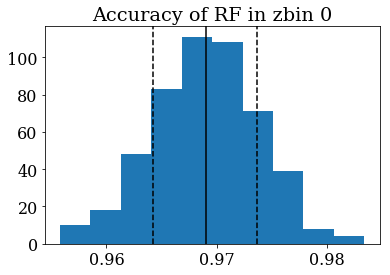

In [94]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist(test_acc_list)

mu  = np.mean(test_acc_list)
upper = np.percentile(test_acc_list, 84)
lower = np.percentile(test_acc_list, 16)
print "mean:", mu
print "84th:", upper
print "16th:", lower

ax.axvline(mu, color='k', ls='-')
ax.axvline(lower, color='k', ls='--')
ax.axvline(upper, color='k', ls='--')
ax.set(title='Accuracy of RF in zbin %d' % testn)

In [95]:
# Check everything is the same length
print len(zbins)
print len(rf_classifiers)
print len(actuals)
print len(predictions)

8
8
8
8


In [96]:
# Calculate the confusion matrix for each zbin's predictions
zbin_cm_list = []
for i in range(len(rf_classifiers)):
#     print "bin 1:"
    cm_list  = [ConfusionMatrix(a, p) for (a, p) in zip(actuals[i], predictions[i])]
    zbin_cm_list.append(cm_list)
#     print cm
#     print

## Display Performance vs. Distance

In [97]:
# Check the results, should match tests from above
zbin_cm_list[0][23]

Predicted  0.0   Ia  __all__
Actual                      
0.0        617   18      635
Ia          21  623      644
__all__    638  641     1279

In [98]:
zbin_stats = {'ACC': [],
              'TPR': [],
              'TNR': [],
              'FPR': [],
              'FNR': [],
              }

for cm_list in zbin_cm_list:

    acc_list = [cm.ACC for cm in cm_list]
    acc_mean = np.mean(acc_list)
    zbin_stats['ACC'].append([acc_mean, 
                              acc_mean - np.percentile(acc_list, 16),
                              np.percentile(acc_list, 84) - acc_mean])
    
    tpr_list = [cm.TPR for cm in cm_list]
    tpr_mean = np.mean(tpr_list)
    zbin_stats['TPR'].append([tpr_mean, 
                              tpr_mean - np.percentile(tpr_list, 16),
                              np.percentile(tpr_list, 84) - tpr_mean])
    
    tnr_list = [cm.TNR for cm in cm_list]
    tnr_mean = np.mean(tnr_list),
    zbin_stats['TNR'].append([tnr_mean, 
                              tnr_mean - np.percentile(tnr_list, 16),
                              np.percentile(tnr_list, 84) - tnr_mean])
    
    fpr_list = [cm.FPR for cm in cm_list]
    fpr_mean = np.mean(fpr_list)
    zbin_stats['FPR'].append([fpr_mean, 
                              fpr_mean - np.percentile(fpr_list, 16),
                              np.percentile(fpr_list, 84) - fpr_mean])
    
    fnr_list = [cm.FNR for cm in cm_list]
    fnr_mean = np.mean(fnr_list)
    zbin_stats['FNR'].append([np.mean(fnr_list), 
                              fnr_mean - np.percentile(fnr_list, 16),
                              np.percentile(fnr_list, 84) - fnr_mean])


zbin_acc = np.asarray(zbin_stats['ACC'])
zbin_tpr = np.asarray(zbin_stats['TPR'])
zbin_tnr = np.asarray(zbin_stats['TNR'])
zbin_fpr = np.asarray(zbin_stats['FPR'])
zbin_fnr = np.asarray(zbin_stats['FNR'])

In [99]:
zbins = np.array(zbins)

In [100]:
zbinwidths = [(z[1]-z[0])/2. for z in zbins]

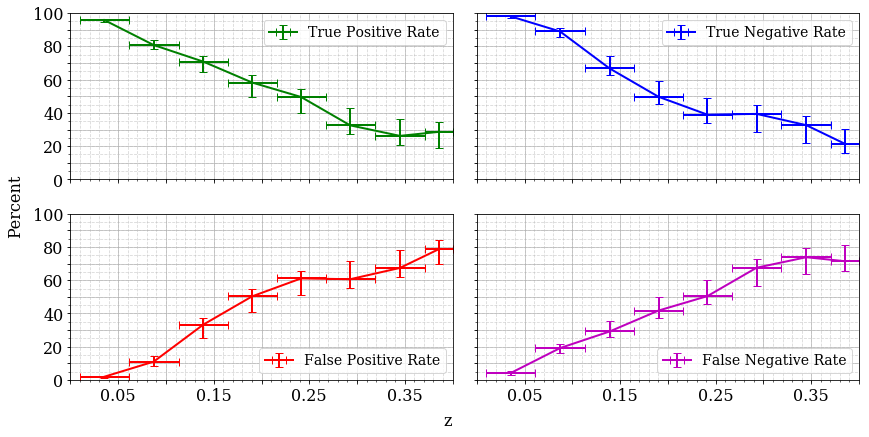

In [103]:
fig, axes = plt.subplots(2,2, figsize=(12,6), sharex=True, sharey=True)

# axes[0,0].errorbar(zbin_means, zbin_acc*100, xerr=zbinwidths, 
#             color='k', lw=2, label='Accuracy')
axes[0,0].errorbar(zbin_means, zbin_tpr[:,0]*100, xerr=zbinwidths,
                   yerr=[zbin_tpr[:,1]*100, zbin_tpr[:,2]*100],
            color='g', capsize=4, lw=2, label='True Positive Rate')
axes[0,1].errorbar(zbin_means, zbin_tnr[:,0]*100, xerr=zbinwidths, 
                   yerr=[zbin_tnr[:,1]*100, zbin_tnr[:,2]*100],
            color='b', capsize=4, lw=2, label='True Negative Rate')
axes[1,0].errorbar(zbin_means, zbin_fpr[:,0]*100, xerr=zbinwidths, 
                   yerr=[zbin_fpr[:,1]*100, zbin_fpr[:,2]*100],
            color='r', capsize=4, lw=2, label='False Positive Rate')
axes[1,1].errorbar(zbin_means, zbin_fnr[:,0]*100, xerr=zbinwidths, 
                   yerr=[zbin_fnr[:,1]*100, zbin_fnr[:,2]*100],
            color='m', capsize=4, lw=2, label='False Negative Rate')

fig.text(0, 0.5, 'Percent', va='center', ha='center', rotation='vertical')
fig.text(0.5, 0, 'z', va='center', ha='center', rotation='horizontal')

axes[0,0].set(ylim=[0,100], xlim=[0, 0.4])

plt.subplots_adjust(wspace=0, hspace=0)

for ax in axes[0,:]:
    ax.legend(loc='upper right', fontsize=14)
    
for ax in axes[1,:]:
    ax.legend(loc='lower right', fontsize=14)

for ax in axes.flatten():    
    ax.set_yticks(np.arange(0, 100, 5),  minor=True)
    ax.set_xticks(np.arange(0,0.4,0.01), minor=True)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.set_xticks(np.arange(0,0.41,0.05))
    ax.grid(which='major', alpha=0.75)
    ax.grid(which='minor', alpha=0.5, ls='--')

    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
        
    for label in ax.yaxis.get_ticklabels()[1::2]:
        label.set_visible(False)
        
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/'
savedir += 'thesis/Figures/'
savename = 'residual_polyfit_distscaling_stats_vs_distance_zbin5000.png'
# savename = 'residual_gaussfit_distscaling_stats_vs_distance_zbin5000.png'

# plt.savefig(savedir + savename,
#            format='png', dpi=300, bbox_inches='tight')

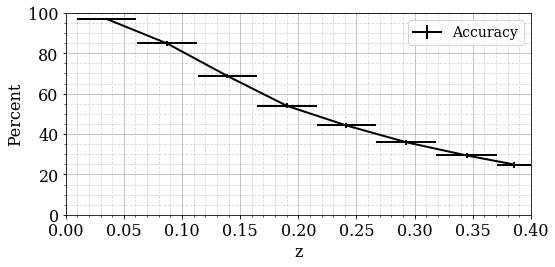

In [104]:
fig, ax = plt.subplots(1,1, figsize=(8,4), sharex=True, sharey=True)

ax.errorbar(zbin_means, zbin_acc[:,0]*100, xerr=zbinwidths, 
            yerr=[zbin_acc[:,1]*100, zbin_acc[:,2]*100], color='k', lw=2, label='Accuracy')

ax.set(ylabel='Percent', xlabel='z', ylim=[0,100], xlim=[0, 0.4])

ax.legend(loc='upper right', fontsize=14)
ax.set_yticks(np.arange(0, 100, 5),  minor=True)
ax.set_xticks(np.arange(0,0.4,0.01), minor=True)
ax.grid(which='major', alpha=0.75)
ax.grid(which='minor', alpha=0.5, ls='--')
    
fig.tight_layout()

savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/'
savedir += 'thesis/Figures/'
savename = 'residual_polyfit_distscaling_acc_vs_distance_zbin5000.png'
# savename = 'residual_gaussfit_distscaling_acc_vs_distance_zbin5000.png'

# plt.savefig(savedir + savename,
#            format='png', dpi=300, bbox_inches='tight')